# ipynb for a 1-D CNN for classifying ECGs
Best results found so far used:
    * 3 VCG leads concatenated
    * 200 buffer, 150 shift (looking at QRS -> T lump)
    * Input data chunked into 10000 healthy and 10000 unhealthy samples
    * Peak finder threshold of 0.02 on differentiated and absoluted input data 
    (then it is returned to undiff, unabs data before it is fed in)
    * Trained over 1 epoch.
    * The CNN:
        * Conv with 32 features, map 5 wide.
        * 2 wide max pool.
        * Conv 64 features, map 5 wide.
        * 2 wide max pool.
        * 1024 neuron dense layer, L2 regularisation with weight_decay=0.001.
        * 50% dropout layer.
        * 2 wide softmax layer.
        * ADAM optimiser with learning_rate=0.00001.
        * Loss function is categorical x-entropy.
        
This gives a result of Sensitivity: 1.0 Specifity: 0.9965 Accuracy: 0.9982 for data taken from the training set (but not trained with).
And Sensitivity: 0.9988 Specifity: 0.9959 Accuracy: 0.9974 on patients it hasn't seen before.

In [1]:
import tensorflow as tf
#import tensorflow.contrib.learn.python.learn as learn
import tflearn 
import scipy as sp
import numpy as np 
import matplotlib.pyplot as plt
from random import shuffle, randint
from sklearn.utils import shuffle as mutualShuf
import os
import pandas as pd
import sklearn
import datetime
%matplotlib inline

# Import and process data

In [3]:
def importData(filepath):
    ppt = np.genfromtxt(filepath)
    dppt = np.diff(np.transpose(ppt)) 
    print(filepath, "Shape:", dppt[1:16,:].shape)
    return dppt[1:16,:]

pathIll = "./inData/clean_ecg/ill/"
pathHealth = "./inData/clean_ecg/health/"
illLst = []
healthLst = []

for file in os.listdir(pathIll):
    illLst.append(importData(pathIll+file))
for file in os.listdir(pathHealth):
    healthLst.append(importData(pathHealth+file))

./inData/clean_ecg/ill/s0198lre.txt Shape: (15, 115199)
./inData/clean_ecg/ill/s0389lre.txt Shape: (15, 115199)
./inData/clean_ecg/ill/s0411lre.txt Shape: (15, 115199)
./inData/clean_ecg/ill/s0559_re.txt Shape: (15, 120011)
./inData/clean_ecg/ill/s0495_re.txt Shape: (15, 120011)
./inData/clean_ecg/ill/s0339lre.txt Shape: (15, 115199)
./inData/clean_ecg/ill/s0362lre.txt Shape: (15, 115199)
./inData/clean_ecg/ill/s0356lre.txt Shape: (15, 115199)
./inData/clean_ecg/ill/s0409lre.txt Shape: (15, 115199)
./inData/clean_ecg/ill/s0378lre.txt Shape: (15, 115199)
./inData/clean_ecg/ill/s0416lre.txt Shape: (15, 115199)
./inData/clean_ecg/ill/s0348lre.txt Shape: (15, 115199)
./inData/clean_ecg/ill/s0225lre.txt Shape: (15, 115199)
./inData/clean_ecg/ill/s0417lre.txt Shape: (15, 115199)
./inData/clean_ecg/ill/s0375lre.txt Shape: (15, 115199)
./inData/clean_ecg/ill/s0352lre.txt Shape: (15, 115199)
./inData/clean_ecg/ill/s0373lre.txt Shape: (15, 115199)
./inData/clean_ecg/ill/s0235lre.txt Shape: (15, 

In [4]:
# If 0 <= lead < 15, then output that lead number. If lead = 15 output a cat array of standard ECG leads.
# If lead == 16 only output Frank leads vx, vy, vz. If lead is anything else output whole dataset flattened.
# If lead == 17 output all leads in a cat array.
lead = 16

if 0 <= lead < 15:
    print("Selecting lead", lead)
    healthPat = np.concatenate((healthLst), axis=1)[lead]
    illPat = np.concatenate((illLst), axis=1)[lead]
    healthPat = np.reshape(healthPat, (1,-1))
    illPat = np.reshape(illPat, (1,-1))

elif lead == 15:
    print("Outputting standard ECG leads")
    healthPat = np.concatenate((healthLst[:]), axis=1)[0:12]
    illPat = np.concatenate((illLst[:]), axis=1)[0:12]

elif lead == 16:
    print("Outputing Frank leads")
    healthPat = np.concatenate((healthLst[:]), axis=1)[12:15]
    illPat = np.concatenate((illLst[:]), axis=1)[12:15]
    
elif lead == 17:
    print("Outputing all leads")
    healthPat = np.concatenate((healthLst[:]), axis=1)
    illPat = np.concatenate((illLst[:]), axis=1)
    
else:
    print("Lead says", lead, "so selecting whole thing")
    healthPat = np.hstack(np.concatenate((healthLst[:]), axis=1))
    illPat = np.hstack(np.concatenate((healthLst[:]), axis=1))
    healthPat = np.reshape(healthPat, (1,-1))
    illPat = np.reshape(illPat, (1,-1))
    
print(healthPat.shape, illPat.shape)

Outputing Frank leads
(3, 4652605) (3, 3811191)


In [5]:
def findAbove(arr, threshold, skip):
    """
    Return indices for values above threshhold in array, arr. Pass over skip amount to reduce 
    number of similar ECGs.
    """
    inlst = []
    for index, item in enumerate(arr):
        if item >= threshold:
            inlst.append(index)
            
    return inlst[::skip]

def getSamples(Arr, indexArr, buffer, shift):
    """
    Get samples for inputting into CNN. Buffer is "pixels" returned either side of peak in indexArr.
    Shift is amount the ECG is shifted from the peak centre.
    """
    sampleArr = []
    for index, item in enumerate(indexArr):
        if Arr[:, item-buffer+shift:item+buffer+shift].shape != (Arr.shape[0], buffer*2):
            pass
        else:
            sampleArr.append(Arr[:, item-buffer+shift:item+buffer+shift])

    return np.array(sampleArr)

def processClassData(classData):
    """
    Process classData.
    
    Returns a one-hot array of shape [len(classData), 2].
    """
    # Convert label data to one-hot array
          
    classDataOH = np.zeros((len(classData),2))
    classDataOH[np.arange(len(classData)), classData] = 1
    
    return classDataOH

def visualiseData(ecgData, classData, gridSize, axis):
    """
    Plot labelled example data in a gridSize*gridSize grid.
    If Axis is True return plot with labelled axes.
    """
    fig, ax = plt.subplots(gridSize, gridSize)
    plt.suptitle("Labelled example data")
    r = randint(0,len(classData)-16)
    k = 0
    for i in np.arange(0,gridSize,1):
        for j in np.arange(0,gridSize,1):
            k = k + 1
            ax[i,j].plot(ecgData[r+k])
            if axis == False:
                ax[i,j].axis("off")
            ax[i,j].annotate(classData[r+k], xy=(0, 0), xycoords='axes points',\
                        size=10, ha='left', va='top')

def undiff(ecgData, buffer):
    """
    Reverse the differentiation done earlier, through np.cumsum.
    """
    for i in np.arange(0,ecgData.shape[0],1):
        for j in np.arange(0,ecgData.shape[1],1):
            ecgData[i,j] = np.cumsum(ecgData[i,j])
    ecgData = np.reshape(ecgData, (-1, buffer*2, 1))
    return ecgData            

def chunkify(lst,n):
    """ Chunk a list into n chunks of approximately equal size """
    return [ lst[i::n] for i in range(n) ]

def splitData(coilData, classData):
    """
    Split data into healthy and ill types.
    """
    illData = []
    healthData = []
    
    for index, item in enumerate(classData):
        if item == 1:
            illData.append(coilData[index])
        if item == 0:
            healthData.append(coilData[index])
            
    return illData, healthData

def functionTownCat(illArr, healthArr, illThreshold, healthThreshold, skip, shift, buffer, shuffle):
    """
    Return the processed ecgData (each "heartbeat") with the leads concatenated into a 2d array,
    and the classData (one-hot).
    If shuffle is true, shuffle data.
    """
    # Get the samples using my crude peak finder
    illPeakArr = findAbove(np.abs(illArr[0]), illThreshold, skip)
    sampleArrI = getSamples(illArr, np.array(illPeakArr), buffer, shift)
    
    healthPeakArr = findAbove(np.abs(healthArr[0]), healthThreshold, skip)
    sampleArrH = getSamples(healthArr, np.array(healthPeakArr), buffer, shift)
    
    # Average over chunks of ~10000 ECG heartbeats
    chunkyI = chunkify(sampleArrI, 10000)
    chunkyH = chunkify(sampleArrH, 10000)
    avgI = []
    avgH = []
    
    for i in np.arange(0,len(chunkyI),1):
        avgI.append(np.mean(chunkyI[i], axis=0))
        
    for i in np.arange(0,len(chunkyH),1):
        avgH.append(np.mean(chunkyH[i], axis=0))
    
    sampleArrI = np.array(avgI)
    sampleArrH = np.array(avgH)
    
    print("ill samples", sampleArrI.shape)
    print("healthy samples", sampleArrH.shape)
    
    # Label the data
    classData = []
    for i in np.arange(0, sampleArrI.shape[0], 1):
        classData.append(1)
    for i in np.arange(0, sampleArrH.shape[0], 1):
        classData.append(0)
    ecgData = np.concatenate((sampleArrI, sampleArrH), axis=0)
                        
    if shuffle == True:
        classData, ecgData = mutualShuf(np.array(classData), ecgData, random_state=0)    
    
    classDataOH = processClassData(classData)
    return ecgData, classDataOH, classData

buffer = 200
bufferxL = buffer*illPat.shape[0]
healthThreshold = 0.02
illThreshold = 0.02
skip = 1
shift = 150
shuf = True

ecgData, classDataOH, classData = functionTownCat(illPat, healthPat, illThreshold, healthThreshold, skip,\
                                               shift, buffer, shuf)
# Reintegrate the found values...
ecgData = undiff(ecgData, bufferxL)
# Take 20% for testing later:
testData = ecgData[:round(ecgData.shape[0]*0.2)]
trainData = ecgData[round(ecgData.shape[0]*0.2):]
testLabels = classDataOH[:round(ecgData.shape[0]*0.2)]
trainLabels = classDataOH[round(ecgData.shape[0]*0.2):]

ill samples (10000, 3, 400)
healthy samples (10000, 3, 400)


(20000, 1200, 1)


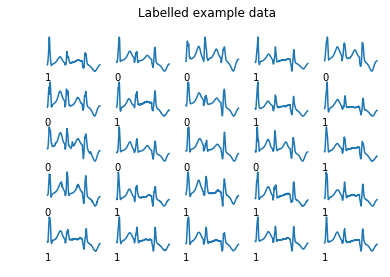

In [6]:
print(ecgData.shape)
visualiseData(ecgData, classData, 5, False)
#plt.savefig("./outData/figures/exampleDataECGundiff.pdf")

# Neural Network

In [7]:
sess = tf.InteractiveSession()
tf.reset_default_graph()
tflearn.initializations.normal()

# Input layer:
net = tflearn.layers.core.input_data(shape=[None, bufferxL*2, 1])

# First layer:
net = tflearn.layers.conv.conv_1d(net, 32, 5, activation="leaky_relu")
net = tflearn.layers.conv.max_pool_1d(net, 2)

# Second layer:
net = tflearn.layers.conv.conv_1d(net, 64, 5, activation="leaky_relu")
net = tflearn.layers.conv.max_pool_1d(net, 2)

# Fully connected layer 1:
net = tflearn.layers.core.fully_connected(net, 1024, regularizer="L2", weight_decay=0.001, activation="leaky_relu")

# Dropout layer:
net = tflearn.layers.core.dropout(net, keep_prob=0.5)

# Output layer:
net = tflearn.layers.core.fully_connected(net, 2, activation="softmax")

net = tflearn.layers.estimator.regression(net, optimizer='adam', loss='categorical_crossentropy',\
                         learning_rate=0.00001)

In [8]:
model = tflearn.DNN(net, tensorboard_verbose=3)
model.fit(trainData, trainLabels, n_epoch=1, show_metric=True)

Training Step: 250  | total loss: 0.19253
| Adam | epoch: 001 | loss: 0.19253 - acc: 0.9979 -- iter: 16000/16000
Training Step: 250  | total loss: 0.19253
| Adam | epoch: 001 | loss: 0.19253 - acc: 0.9979 -- iter: 16000/16000
--


In [9]:
# Save model?
#now = datetime.datetime.now()
#model.save("./outData/models/cleanECG_undiff_FrankCAT2_"+now.isoformat()+"_.tflearn")

# Test accuracy of model(s)
## 20% of training data set aside for testing (4000 "heartbeats")

In [10]:
#model.load("./outData/models/cleanECG_undiff_20e_300buff_0shift_2017-02-21T19:20:35.702943_.tflearn")
#model.load("./outData/models/cleanECG_undiff_20e_150buff_2017-02-21T16:15:02.602923_.tflearn")
labellst = classData[:round(ecgData.shape[0]*0.2)]
healthTest = []
illTest = []
for index, item in enumerate(labellst):
    if item == 1:
        illTest.append(testData[index])
    if item == 0:
        healthTest.append(testData[index])

healthLabel = np.tile([1,0], (len(healthTest), 1))
illLabel = np.tile([0,1], (len(illTest), 1))
                      
print("Sensitivity:", model.evaluate(np.array(healthTest), healthLabel), "Specifity:",\
    model.evaluate(np.array(illTest), illLabel),\
    "Accuracy:", model.evaluate(testData, testLabels))

Sensitivity: [1.0] Specifity: [0.99648946840521568] Accuracy: [0.99824999999999997]


## What if the model hasn't seen data from the patient?

In [13]:
tpathIll = "./inData/clean_ecg/testIll/"
tpathHealth = "./inData/clean_ecg/testHealth/"
tillLst = []
thealthLst = []

for file in os.listdir(tpathIll):
    tillLst.append(importData(tpathIll+file))
for file in os.listdir(tpathHealth):
    thealthLst.append(importData(tpathHealth+file))

./inData/clean_ecg/testIll/s0177lre.txt Shape: (15, 115199)
./inData/clean_ecg/testIll/s0044lre.txt Shape: (15, 115199)
./inData/clean_ecg/testIll/s0088lre.txt Shape: (15, 115199)
./inData/clean_ecg/testIll/s0219lre.txt Shape: (15, 115199)
./inData/clean_ecg/testIll/s0215lre.txt Shape: (15, 115199)
./inData/clean_ecg/testIll/s0174lre.txt Shape: (15, 115199)
./inData/clean_ecg/testIll/s0314lre.txt Shape: (15, 115199)
./inData/clean_ecg/testIll/s0145lre.txt Shape: (15, 115199)
./inData/clean_ecg/testIll/s0133lre.txt Shape: (15, 115199)
./inData/clean_ecg/testIll/s0185lre.txt Shape: (15, 115199)
./inData/clean_ecg/testIll/s0080lre.txt Shape: (15, 115199)
./inData/clean_ecg/testIll/s0124lre.txt Shape: (15, 115199)
./inData/clean_ecg/testIll/s0100lre.txt Shape: (15, 115199)
./inData/clean_ecg/testIll/s0119lre.txt Shape: (15, 115199)
./inData/clean_ecg/testIll/s0131lre.txt Shape: (15, 115199)
./inData/clean_ecg/testIll/s0127lre.txt Shape: (15, 115199)
./inData/clean_ecg/testIll/s0095lre.txt 

Outputing Frank leads
ill samples (10000, 3, 400)
healthy samples (10000, 3, 400)
Sensitivity: 0.9988 Specifity: 0.9959 Accuracy: 0.99735


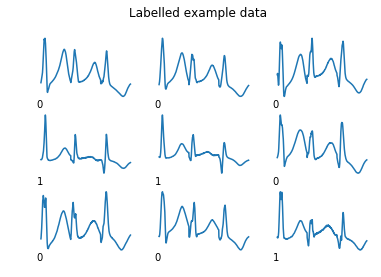

In [14]:
if 0 <= lead < 15:
    print("Selecting lead", lead)
    thealth = np.concatenate((thealthLst), axis=1)[lead]
    till = np.concatenate((tillLst), axis=1)[lead]
    thealth = np.reshape(thealth, (1,-1))
    till = np.reshape(till, (1,-1))

elif lead == 15:
    print("Outputting array of standard ECG leads")
    thealth = np.concatenate((thealthLst[:]), axis=1)[0:12]
    till = np.concatenate((tillLst[:]), axis=1)[0:12]
    
elif lead == 16:
    print("Outputing Frank leads")
    thealth = np.concatenate((thealthLst[:]), axis=1)[12:15]
    till = np.concatenate((tillLst[:]), axis=1)[12:15]       
    
elif lead == 17:
    print("Outputing all leads")
    thealth = np.concatenate((thealthLst[:]), axis=1)
    till = np.concatenate((tillLst[:]), axis=1)    
    
else:
    print("Lead says", lead, "so selecting whole thing")
    thealth = np.hstack(np.concatenate((thealthLst[:]), axis=1))
    till = np.hstack(np.concatenate((tillLst[:]), axis=1))
    thealth = np.reshape(thealth, (1,-1))
    till = np.reshape(till, (1,-1))
    
                          
unseenData, unseenClassOH, unseenClass = functionTownCat(till, thealth, illThreshold, healthThreshold, \
                                                   skip, shift, buffer, True)
    
# Undifferentiate values
unseenData = undiff(unseenData, bufferxL)
tillarr, thealtharr = splitData(unseenData, unseenClass)
    
sens = model.evaluate(np.array(thealtharr), np.tile([1,0], (len(thealtharr), 1)))[0]
spec = model.evaluate(np.array(tillarr), np.tile([0,1], (len(tillarr), 1)))[0]
lenh = len(thealtharr)
leni = len(tillarr)
visualiseData(unseenData, unseenClass, 3, False)    

print("Sensitivity:", sens,\
      "Specifity:", spec,\
      "Accuracy:", ((sens*lenh+spec*leni)/(lenh+leni)))